# Sheffield Solar PV Live API Generation Data (MWh) ETL

##### In this Notebook we are exploring the PVLive API by Sheffield Solar (https://github.com/SheffieldSolar/PV_Live-API)

We are extracting the embedded (connected to distribution network) solar generation (MWh) from assets connected to Grid Supply Points (GSPs) across the UK. We will develop functions to:

* Extract the half hourly generation of the embedded solar at given GSPs for a specified date range.
* Clean and transform the data to be used with the GSP **capacity data** and weather data which will be accessed via the **Openmeteo** API in another notebook.


In [47]:
# Environments
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import pytz
from datetime import datetime
from pvlive_api import PVLive

## 1.0 Extracting Generation Data from PVLive API

In [48]:
# Initiating PVLive API as per GIT repo instructions: https://github.com/SheffieldSolar/PV_Live-API
pvl = PVLive(
    retries=3, # Optionally set the number of retries when intermittent issues are encountered
    proxies=None, # Optionally pass a dict of proxies to use when making requests
    ssl_verify=True, # Optionally disable SSL certificate verification (not advised!)
    domain_url="api.pvlive.uk", # Optionally switch between the prod and FOF APIs
)

In [49]:
# getting data from 1 gsp for a given date range using the between function of the PVLive API

start_utc = datetime(2025, 1, 1, 0, 0, tzinfo=pytz.UTC) # ensure dates are in a format legible by the between function
end_utc   = datetime(2025, 12, 31, 23, 30, tzinfo=pytz.UTC)

generation_df = pvl.between(
            start=start_utc,
            end=end_utc,
            entity_type="gsp",
            entity_id=123,
            dataframe=True,
            extra_fields=""
        )
generation_df

,gsp_id,datetime_gmt,generation_mw
0,123,2025-01-31 00:00:00+00:00,0.0
1,123,2025-01-30 23:30:00+00:00,0.0
2,123,2025-01-30 23:00:00+00:00,0.0
3,123,2025-01-30 22:30:00+00:00,0.0
4,123,2025-01-30 22:00:00+00:00,0.0
...,...,...,...
17507,123,2025-12-27 08:00:00+00:00,0.0
17508,123,2025-12-27 07:30:00+00:00,0.0
17509,123,2025-12-27 07:00:00+00:00,0.0
17510,123,2025-12-27 06:30:00+00:00,0.0


#### Notes on the format of the generation data:

* As expected the time-series is in half hourly format - where the capacity data was in monthly format
* The only GSP identifier is the gsp_id number - we'll need a plan for merging this with the capacity and NESO dfs

Next steps:

* quickly check the generation comes out in expected seasonal format
* create functions to align with the capacity and location dataframes

##### 1.1 Plotting the generation data from 1 GSP

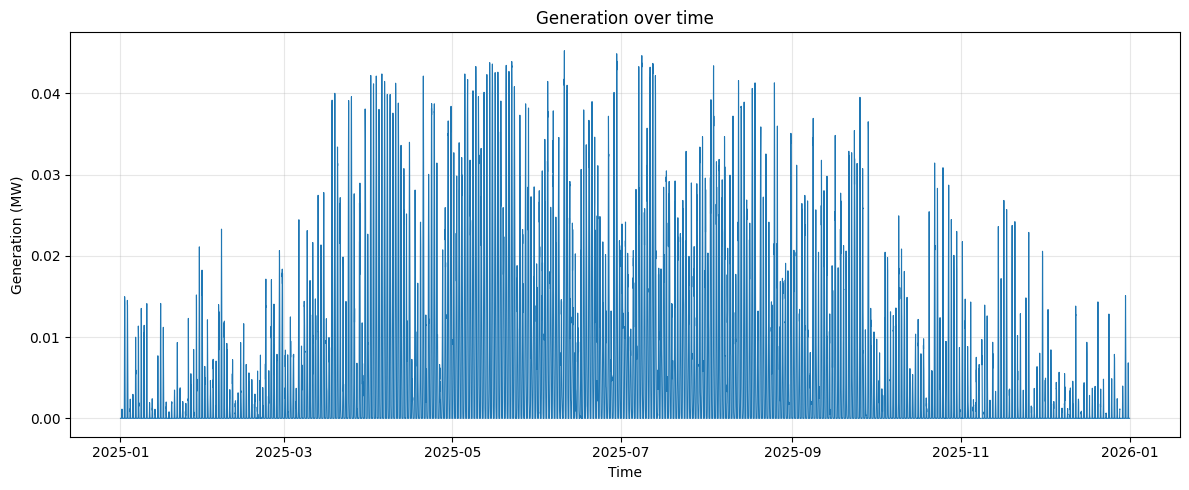

In [50]:
df = generation_df.copy()
df['datetime_gmt'] = pd.to_datetime(df['datetime_gmt'])
df = df.sort_values('datetime_gmt').set_index('datetime_gmt')

plt.figure(figsize=(12,5))
plt.plot(df.index, df['generation_mw'], linewidth=0.8)
plt.xlabel('Time')
plt.ylabel('Generation (MW)')
plt.title('Generation over time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Generation generally matches the expected profile with higher performance in the summer than in the winter.

Let's explore generation at a more granluar level

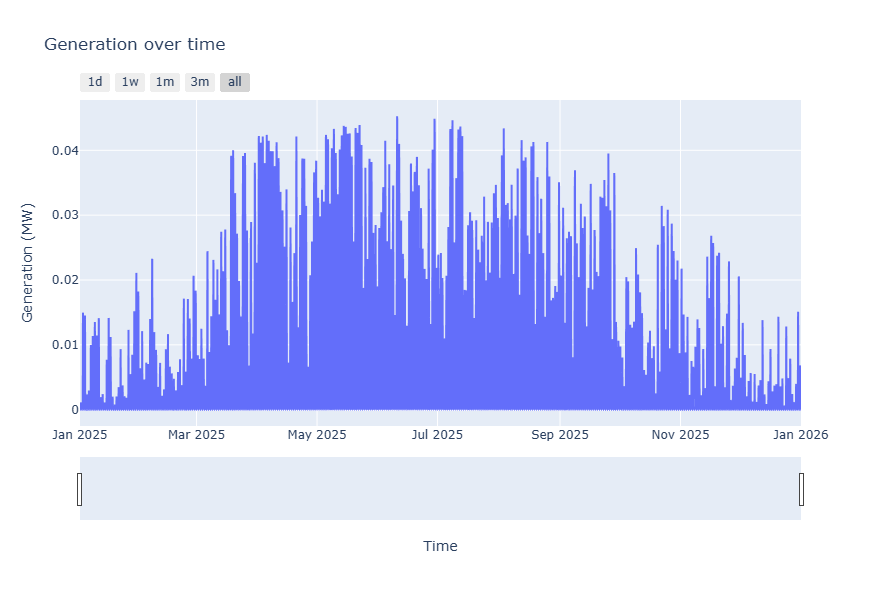

In [51]:
df = generation_df.copy()
df['datetime_gmt'] = pd.to_datetime(df['datetime_gmt'])
df = df.sort_values('datetime_gmt')

fig = px.line(df, x='datetime_gmt', y='generation_mw',
              title='Generation over time',
              labels={'datetime_gmt':'Time', 'generation_mw':'Generation (MW)'},
              hover_data={'gsp_id':True})

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=3, label="3m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    hovermode="x unified",
    height=600
)

fig.show()


Daily production profiles also match the expected output, with the solar bell curve visible on a daily basis - let's now explore how to merge with the capacity dataset

##### 2.0 Preparing for generation data - function building continued for cumulative capacity and locaitons

##### 2.1 First we pull the functions which extracts the cumulative capacity and location which:

* Extracts all GSPs cumulative capacities since 1995
* Extracts GSP locational data from NESO, cleans and aligns with capacity data
* Builds a table of all 299 GSPs cumulative capacities, and a;
* Separate table with all 299 GSPs locational data

The idea of building these functions is to ensure there is a robust alignment between capacity, locaitonal and generation data. At this stage we are building a platform to add the generation data to.

In [52]:
def load_mwp(region="gsp", include_history=True):
    """
    Load and return the MWp deployment dataframe as mwp_df via pvl.deployment.
    """
    mwp_df = pvl.deployment(region=region, include_history=include_history)
    return mwp_df

def load_gsp():
    """
    Load and return the GSP info dataframe as gsp_df from CSV.
    """
    gsp_df = pd.read_csv('../data/gsp_info.csv')
    return gsp_df

def merge_gsp_location(mwp_df, gsp_df, gsp_col_mwp='GSPs', gsp_col_gsp='gsp_name'):
    """
    Return a copy of mwp_df with columns gsp_lat, gsp_lon, region_name merged from gsp_df.
    Matching is done case-insensitive and with whitespace stripped.
    Remove the 'unkown' rows from the mwp_df - presumably misspelling of unknown.
    Drop any rows with missing values.
    
    """
    # Make copies to avoid mutating inputs
    mwp = mwp_df.copy()
    gsp = gsp_df.copy()

    # Normalize join keys by aligning to string, stripping and putting in upper case
    mwp['_gsp_key'] = mwp[gsp_col_mwp].astype(str).str.strip().str.upper()
    gsp['_gsp_key'] = gsp[gsp_col_gsp].astype(str).str.strip().str.upper()

    # Select only the columns we want to bring across (plus join key)
    to_merge = gsp[['_gsp_key', 'gsp_id', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']].drop_duplicates('_gsp_key')

    # Left merge so all mwp rows are kept
    merged = mwp.merge(to_merge, on='_gsp_key', how='left')

    # drop all rows where ther are NaN values - return only the 299 intersection GSPs
    merged = merged.dropna(how='any')
    
    # return the df where not equal to unkown
    merged = merged[merged[gsp_col_mwp] != 'unkown']
    
    # Drop helper key
    merged = merged.drop(columns=['_gsp_key'])

    return merged
    
def gsp_locations(merged_df, gsp_col='GSPs'):
    """
    Return a DataFrame with one row per unique GSP containing
    gsp_col, gsp_lat, gsp_lon, region_name, pes_id, and a combined
    'GSP_region' column formatted "GSPs | region_name".
    """
    gsp_locations_list = (
        merged_df
        .drop_duplicates(subset=[gsp_col])[[gsp_col, 'gsp_id', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']]
        .reset_index(drop=True)
    )
    gsp_locations_list['GSP_region'] = gsp_locations_list[gsp_col].astype(str) + ' | ' + gsp_locations_list['region_name'].astype(str)
    return gsp_locations_list

def wide_cumul_capacity(merged_df, time_col='install_month', gsp_col='GSPs', value_col='cumul_capacity_mwp'):
    """
    Return a wide DataFrame with:
    - one column for the time (time_col)
    - one column per GSP (column name = GSP identifier)
    - cells = value_col (cumulative capacity MWP)
    """
    import pandas as pd
    df = merged_df.copy()
    try:
        df[time_col] = pd.to_datetime(df[time_col])
    except Exception:
        pass
    wide = df.pivot_table(index=time_col, columns=gsp_col, values=value_col, aggfunc='first')
    wide = wide.reset_index()  # make time a regular column
    return wide
    
# Create the variables from the above functions
mwp_df = load_mwp()
gsp_df = load_gsp()
merged_df = merge_gsp_location(mwp_df, gsp_df)
gsp_locations_list = gsp_locations(merged_df)
capacity_growth = wide_cumul_capacity(merged_df)

In [53]:
# check they function
merged_df

,release,GSPs,install_month,dc_capacity_mwp,system_count,sm_count,cumul_capacity_mwp,gsp_id,gsp_lat,gsp_lon,region_name,pes_id
0,20251024,NETS,1995-09-01,0.00000,0,0,0.000000,255.0,54.948421,-4.491001,Newton Stewart,18.0
1,20251024,NETS,1995-10-01,0.00000,0,0,0.000000,255.0,54.948421,-4.491001,Newton Stewart,18.0
2,20251024,NETS,1995-11-01,0.00000,0,0,0.000000,255.0,54.948421,-4.491001,Newton Stewart,18.0
3,20251024,NETS,1995-12-01,0.00000,0,0,0.000000,255.0,54.948421,-4.491001,Newton Stewart,18.0
4,20251024,NETS,1996-01-01,0.00000,0,0,0.000000,255.0,54.948421,-4.491001,Newton Stewart,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...
120541,20251024,HAWP_6,2025-06-01,0.20912,76,0,25.669796,83.0,54.805250,-1.401470,Hawthorn Pit,15.0
120542,20251024,HAWP_6,2025-07-01,0.16223,49,0,25.832026,83.0,54.805250,-1.401470,Hawthorn Pit,15.0
120543,20251024,HAWP_6,2025-08-01,0.41472,155,0,26.246746,83.0,54.805250,-1.401470,Hawthorn Pit,15.0
120544,20251024,HAWP_6,2025-09-01,0.45399,165,0,26.700736,83.0,54.805250,-1.401470,Hawthorn Pit,15.0


In [54]:
gsp_locations_list

,GSPs,gsp_id,gsp_lat,gsp_lon,region_name,pes_id,GSP_region
0,NETS,255.0,54.948421,-4.491001,Newton Stewart,18.0,NETS | Newton Stewart
1,CHAP,184.0,55.016530,-3.229370,Chapelcross,18.0,CHAP | Chapelcross
2,BISW_1,133.0,52.311720,-2.240280,Bishops Wood,14.0,BISW_1 | Bishops Wood
3,PORD,262.0,55.873420,-4.254200,Port Dundas,18.0,PORD | Port Dundas
4,BROR_P,176.0,58.020320,-3.875640,Brora,17.0,BROR_P | Brora
...,...,...,...,...,...,...,...
294,REBR_3,28.0,51.588030,0.044630,Redbridge,12.0,REBR_3 | Redbridge
295,SHIN_P,268.0,57.943890,-4.412320,Shin,17.0,SHIN_P | Shin
296,LEGA_1,95.0,53.028230,-3.052460,Legacy,13.0,LEGA_1 | Legacy
297,KIIN_P,238.0,56.477150,-4.328190,Killin,17.0,KIIN_P | Killin


In [55]:
capacity_growth

GSPs,install_month,ABHA1,ABNE_P,ABTH_1,ACTL_C,ALNE_P,ALVE1,AMEM_1,ARBR_P,AXMI1,...,WIMBS1,WIOW_P,WISD_1,WISD_6,WMEL_1,WOHI_P,WTHU31,WWEY_1,WYLF_1,WYMOM_1
0,1995-09-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1995-10-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1995-11-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1995-12-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1996-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,2025-06-01,214.240365,30.314837,108.656316,1.840502,4.904954,426.505447,138.856232,27.414044,129.035279,...,28.346643,1.135372,10.759067,1.458922,47.195548,3.329154,2.852032,55.532479,122.709276,74.556895
358,2025-07-01,215.321815,30.433657,109.197696,1.889062,5.053374,427.161497,139.003572,27.561704,129.457959,...,28.722903,1.151372,10.979377,1.501472,47.909488,3.345974,2.856032,56.060649,123.401716,75.319395
359,2025-08-01,216.195355,30.655497,109.598166,1.974042,5.115444,427.782037,139.118002,27.605914,129.763979,...,29.358503,1.154612,11.146627,1.501472,48.672488,3.362024,2.883612,56.647679,124.034016,75.850555
360,2025-09-01,216.893525,30.841157,110.066366,1.997992,5.251374,470.615747,139.316032,27.775074,130.124039,...,29.668713,1.212882,11.275047,1.513542,49.292698,3.422424,2.906452,57.261269,124.608556,76.554975


Confirmed all functions are working so far, now let's add to the capacity and location dfs with generation data

##### 2.1 Function for one GSP generation data

This is our working code from the PVLive API:

In [56]:
start_utc = datetime(2025, 1, 1, 0, 0, tzinfo=pytz.UTC) # ensure dates are in a format legible by the between function
end_utc   = datetime(2025, 12, 31, 23, 30, tzinfo=pytz.UTC)

generation_df = pvl.between(
            start=start_utc,
            end=end_utc,
            entity_type="gsp",
            entity_id=123,
            dataframe=True,
            extra_fields=""
        )
generation_df

,gsp_id,datetime_gmt,generation_mw
0,123,2025-01-31 00:00:00+00:00,0.0
1,123,2025-01-30 23:30:00+00:00,0.0
2,123,2025-01-30 23:00:00+00:00,0.0
3,123,2025-01-30 22:30:00+00:00,0.0
4,123,2025-01-30 22:00:00+00:00,0.0
...,...,...,...
17507,123,2025-12-27 08:00:00+00:00,0.0
17508,123,2025-12-27 07:30:00+00:00,0.0
17509,123,2025-12-27 07:00:00+00:00,0.0
17510,123,2025-12-27 06:30:00+00:00,0.0


##### 2.2 Now let's check:

* All 299 GSPS in the gsp_locations_list can be extracted via the above code to get;
* generation data for a selected period, and;
* there are no NaN values

**The aim of the final working code will be to evaluate each GSP's solar production individually for a given time period (not all at once) so we are just checking the data is there for them all now with this loop, rahter than building into the class**

In [57]:
'''def download_pvlive_by_gsp(start, end, gsp_locations_list, include_national=False, extra_fields=""):
    pvl = PVLive()
    ids = gsp_locations_list['gsp_id'].dropna().astype(int).unique()
    min_id = 0 if include_national else 1
    frames = []
    for gid in ids:
        if gid < min_id:
            continue
        df = pvl.between(
            start=start,
            end=end,
            entity_type="gsp",
            entity_id=int(gid),
            dataframe=True,
            extra_fields=extra_fields
        )
        if df is not None and not df.empty:
            frames.append(df)
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()'''

'def download_pvlive_by_gsp(start, end, gsp_locations_list, include_national=False, extra_fields=""):\n    pvl = PVLive()\n    ids = gsp_locations_list[\'gsp_id\'].dropna().astype(int).unique()\n    min_id = 0 if include_national else 1\n    frames = []\n    for gid in ids:\n        if gid < min_id:\n            continue\n        df = pvl.between(\n            start=start,\n            end=end,\n            entity_type="gsp",\n            entity_id=int(gid),\n            dataframe=True,\n            extra_fields=extra_fields\n        )\n        if df is not None and not df.empty:\n            frames.append(df)\n    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()'

##### This returns an error and we notice some GSP IDs from the Capacity and Locational Data frames are not recognised by the PVLive generation function. Therefore we will embed a 'valid GSP ID list' (from the PVLIVE generaiton between function) into the working list of functions. This will further filter the number of GSPS we can access in the final app but given time frames, clean data is prioritised over completeness.

With that in mind we add this filter to the Class we are building below in **load_gsp** to illustrate the code's progression:

In [58]:
def load_mwp(region="gsp", include_history=True):
    """
    Load and return the MWp deployment dataframe as mwp_df via pvl.deployment.
    """
    mwp_df = pvl.deployment(region=region, include_history=include_history)
    return mwp_df

def load_gsp(gsp_path="../data/gsp_info.csv"):
    """
    Load and return the GSP info dataframe as gsp_df from CSV,
    filtered to only GSPs known to PVLive (pvl.gsp_ids).
    """
    pvl = PVLive()
    valid_ids = set(pvl.gsp_ids)

    gsp_df = pd.read_csv(gsp_path)

    if 'gsp_id' in gsp_df.columns:
        # coerce non-numeric to NaN, drop those rows, cast to int, then filter by PVLive ids
        gsp_df['gsp_id_num'] = pd.to_numeric(gsp_df['gsp_id'], errors='coerce')
        gsp_df = gsp_df[gsp_df['gsp_id_num'].notna()].copy()
        gsp_df['gsp_id_num'] = gsp_df['gsp_id_num'].astype(int)
        gsp_df = gsp_df[gsp_df['gsp_id_num'].isin(valid_ids)].drop(columns=['gsp_id_num']).reset_index(drop=True)

    return gsp_df

def merge_gsp_location(mwp_df, gsp_df, gsp_col_mwp='GSPs', gsp_col_gsp='gsp_name'):
    """
    Return a copy of mwp_df with columns gsp_lat, gsp_lon, region_name merged from gsp_df.
    Matching is done case-insensitive and with whitespace stripped.
    Remove the 'unkown' rows from the mwp_df - presumably misspelling of unknown.
    Drop any rows with missing values.
    
    """
    # Make copies to avoid mutating inputs
    mwp = mwp_df.copy()
    gsp = gsp_df.copy()

    # Normalize join keys by aligning to string, stripping and putting in upper case
    mwp['_gsp_key'] = mwp[gsp_col_mwp].astype(str).str.strip().str.upper()
    gsp['_gsp_key'] = gsp[gsp_col_gsp].astype(str).str.strip().str.upper()

    # Select only the columns we want to bring across (plus join key)
    to_merge = gsp[['_gsp_key', 'gsp_id', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']].drop_duplicates('_gsp_key')    
    merged = mwp.merge(to_merge, on='_gsp_key', how='left') # Left merge so all mwp rows are kept
    merged = merged.dropna(how='any')   # drop all rows where ther are NaN values - return only the 299 intersection GSPs
    merged = merged[merged[gsp_col_mwp] != 'unkown']  # return the df where not equal to unkown
    merged = merged.drop(columns=['_gsp_key'])  # Drop linking key

    return merged
    
def gsp_locations(merged_df, gsp_col='GSPs'):
    """
    Return a DataFrame with one row per unique GSP containing
    gsp_col, gsp_lat, gsp_lon, region_name, pes_id, and a combined
    'GSP_region' column formatted "GSPs | region_name".
    """
    gsp_locations_list = (
        merged_df
        .drop_duplicates(subset=[gsp_col])[[gsp_col, 'gsp_id', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']]
        .reset_index(drop=True)
    )
    gsp_locations_list['GSP_region'] = gsp_locations_list[gsp_col].astype(str) + ' | ' + gsp_locations_list['region_name'].astype(str)
    return gsp_locations_list

def wide_cumul_capacity(merged_df, time_col='install_month', gsp_col='GSPs', value_col='cumul_capacity_mwp'):
    """
    Return a wide DataFrame with:
    - one column for the time (time_col)
    - one column per GSP (column name = GSP identifier)
    - cells = value_col (cumulative capacity MWP)
    """
    import pandas as pd
    df = merged_df.copy()
    try:
        df[time_col] = pd.to_datetime(df[time_col])
    except Exception:
        pass
    wide = df.pivot_table(index=time_col, columns=gsp_col, values=value_col, aggfunc='first')
    wide = wide.reset_index()  # make time a regular column
    return wide
    
# Create the variables from the above functions
mwp_df = load_mwp()
gsp_df = load_gsp()
merged_df = merge_gsp_location(mwp_df, gsp_df)
gsp_locations_list = gsp_locations(merged_df)
capacity_growth = wide_cumul_capacity(merged_df)

##### 2.2 Check the new filter works through gsp_locations_list:

Note the below code block has been taken from the Sheffield Solar PVLive API GitHub repo: https://github.com/SheffieldSolar/PV_Live-API

In [59]:
def download_pvlive_by_gsp(start, end, gsp_locations_list, include_national=False, extra_fields=""):
    pvl = PVLive()
    ids = gsp_locations_list['gsp_id'].dropna().astype(int).unique()
    min_id = 0 if include_national else 1
    frames = []
    for gid in ids:
        if gid < min_id:
            continue
        df = pvl.between(
            start=start,
            end=end,
            entity_type="gsp",
            entity_id=int(gid),
            dataframe=True,
            extra_fields=extra_fields
        )
        if df is not None and not df.empty:
            frames.append(df)
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

start = datetime(2025, 12, 25, 0, 0, tzinfo=pytz.UTC)
end   = datetime(2025, 12, 31, 23, 30, tzinfo=pytz.UTC)

generation_df = download_pvlive_by_gsp(start, end, gsp_locations_list, include_national=False, extra_fields="")
generation_df

,gsp_id,datetime_gmt,generation_mw
0,255,2025-12-31 23:30:00+00:00,0.0
1,255,2025-12-31 23:00:00+00:00,0.0
2,255,2025-12-31 22:30:00+00:00,0.0
3,255,2025-12-31 22:00:00+00:00,0.0
4,255,2025-12-31 21:30:00+00:00,0.0
...,...,...,...
97435,83,2025-12-25 02:00:00+00:00,0.0
97436,83,2025-12-25 01:30:00+00:00,0.0
97437,83,2025-12-25 01:00:00+00:00,0.0
97438,83,2025-12-25 00:30:00+00:00,0.0


* Confirmed! That works and there are no errors, now let's check for:
* NaN values in the generation data, and;
* How many GSPs are matched across all three data sources (capacity, locational and generation)

##### 2.3 Check for NaN Values:

In [60]:
# total and per-column NaN counts
print("Total NaNs:", generation_df.isna().sum().sum())
print(generation_df.isna().sum())

Total NaNs: 2107
gsp_id              0
datetime_gmt        0
generation_mw    2107
dtype: int64


**There are a lot of NaN values in the generation figures which could be for a number of reasons including comms faults and grid faults. However, we are not intending to investigate nature of faults in depth in this report:**

* We are aiming to predict solar generation by weather data, and so interpolation of up to 12 consecutive missing time periods (max 6 hours in either direction) is preferred, given actual generation is likely to have occured, or would have occured in either scenario (comms or grid faults, respectively)
* We interpolate only up to 12 consecutive NaN values in a row to avoid potential errors where NaNs span more than one day potentially causing a skewed bell-curve or accidentally imputing generation to have occured over night.
* If there are other NaNs these can be converted to 0s

In [61]:
df = generation_df.copy()
df['datetime_gmt'] = pd.to_datetime(df['datetime_gmt'])
df = df.sort_values(['gsp_id', 'datetime_gmt']).set_index('datetime_gmt')

df['generation_mw'] = (
    df
    .groupby('gsp_id')['generation_mw']
    .apply(lambda s: s.interpolate(method='time', limit=6, limit_direction='both'))
    .reset_index(level=0, drop=True)
)

df = df.reset_index()
df.head()

,datetime_gmt,gsp_id,generation_mw
0,2025-12-25 00:00:00+00:00,1,0.0
1,2025-12-25 00:30:00+00:00,1,0.0
2,2025-12-25 01:00:00+00:00,1,0.0
3,2025-12-25 01:30:00+00:00,1,0.0
4,2025-12-25 02:00:00+00:00,1,0.0


In [62]:
print("Total NaNs:", df.isna().sum().sum())
print(df.isna().sum())

Total NaNs: 0
datetime_gmt     0
gsp_id           0
generation_mw    0
dtype: int64


##### 2.3 That solves our NaN issue! So we embed the interpolation into the extraction function:

In [63]:
def download_pvlive_by_gsp(start, end, gsp_locations_list, include_national=False, extra_fields=""):
    pvl = PVLive()
    ids = gsp_locations_list['gsp_id'].dropna().astype(int).unique()
    min_id = 0 if include_national else 1
    frames = []
    for gid in ids:
        if gid < min_id:
            continue
        df = pvl.between(
            start=start,
            end=end,
            entity_type="gsp",
            entity_id=int(gid),
            dataframe=True,
            extra_fields=extra_fields
        )
        if df is not None and not df.empty:
            frames.append(df)
    generation_df2 = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

    # interpolate up to 12 consecutive missing periods per GSP
    if not generation_df2.empty:
        generation_df2['datetime_gmt'] = pd.to_datetime(generation_df2['datetime_gmt'])
        generation_df2 = generation_df2.sort_values(['gsp_id', 'datetime_gmt']).set_index('datetime_gmt')
        generation_df2['generation_mw'] = (
            generation_df2
            .groupby('gsp_id')['generation_mw']
            .apply(lambda s: s.interpolate(method='time', limit=12, limit_direction='both'))
            .reset_index(level=0, drop=True)
        )
        generation_df2 = generation_df2.reset_index()

    return generation_df2


In [64]:
from datetime import datetime
import pytz

# define time window (last week of Dec 2025)
start = datetime(2025, 12, 25, 0, 0, tzinfo=pytz.UTC)
end   = datetime(2025, 12, 31, 23, 30, tzinfo=pytz.UTC)

# call the function and assign result
generation_df2 = download_pvlive_by_gsp(start, end, gsp_locations_list, include_national=False, extra_fields="")

# quick checks
print("shape:", generation_df2.shape)
print(generation_df2.dtypes)
print("NaNs per column:\n", generation_df2.isna().sum())
print(generation_df2.head())


shape: (97440, 3)
datetime_gmt     datetime64[ns, UTC]
gsp_id                         int64
generation_mw                float64
dtype: object
NaNs per column:
 datetime_gmt     0
gsp_id           0
generation_mw    0
dtype: int64
               datetime_gmt  gsp_id  generation_mw
0 2025-12-25 00:00:00+00:00       1            0.0
1 2025-12-25 00:30:00+00:00       1            0.0
2 2025-12-25 01:00:00+00:00       1            0.0
3 2025-12-25 01:30:00+00:00       1            0.0
4 2025-12-25 02:00:00+00:00       1            0.0


In [65]:
generation_df2

,datetime_gmt,gsp_id,generation_mw
0,2025-12-25 00:00:00+00:00,1,0.0
1,2025-12-25 00:30:00+00:00,1,0.0
2,2025-12-25 01:00:00+00:00,1,0.0
3,2025-12-25 01:30:00+00:00,1,0.0
4,2025-12-25 02:00:00+00:00,1,0.0
...,...,...,...
97435,2025-12-31 21:30:00+00:00,338,0.0
97436,2025-12-31 22:00:00+00:00,338,0.0
97437,2025-12-31 22:30:00+00:00,338,0.0
97438,2025-12-31 23:00:00+00:00,338,0.0


In [66]:
print("Total NaNs:", generation_df2.isna().sum().sum())
print(generation_df2.isna().sum())

Total NaNs: 0
datetime_gmt     0
gsp_id           0
generation_mw    0
dtype: int64


##### That has cleaned the NaNs across all GSPs for the whole of 2025. We will embed this code therefore in the function which extracts the generation history for a single GSP. We are not going to extract generation from all GSPs in a function, given the CPU cost is much too high,. This exercise was purely to check the functionality of all GSPs when selected using this function.

##### 2.4 Check how many GSPs were pulled through with all 3 filters on:

In [67]:
# number of unique GSPs
num_unique = generation_df2['gsp_id'].nunique()
print("unique GSP count:", num_unique)


unique GSP count: 290


There are 290 GSPs in this list so we have lost another 9 GSPs to the filter but this will be sufficient for this project

##### 2.4 Amending GSP generation extraction function to single GSP to save CPU:

In [68]:
def download_pvlive_for_single_gsp(start, end, gsp_id, gsp_locations_list, include_national=False, extra_fields=""):
    pvl = PVLive()
    
    # Get the valid gsp_ids from gsp_locations_list
    valid_ids = gsp_locations_list['gsp_id'].dropna().astype(int).unique()

    # Check if the provided gsp_id is valid
    if gsp_id not in valid_ids:
        return f"Please select a GSP ID which appears in the GSP capacity list."

    # Fetch data for the specific GSP ID
    df = pvl.between(
        start=start,
        end=end,
        entity_type="gsp",
        entity_id=int(gsp_id),
        dataframe=True,
        extra_fields=extra_fields
    )

    # Interpolate up to 12 consecutive missing periods
    if df is not None and not df.empty:
        df['datetime_gmt'] = pd.to_datetime(df['datetime_gmt'])
        df = df.sort_values(['gsp_id', 'datetime_gmt']).set_index('datetime_gmt')
        df['generation_mw'] = (
            df.groupby('gsp_id')['generation_mw']
            .apply(lambda s: s.interpolate(method='time', limit=12, limit_direction='both'))
            .reset_index(level=0, drop=True)
        )
        df = df.reset_index()

    return df

# Example usage
start = datetime(2025, 12, 25, 0, 0, tzinfo=pytz.UTC)
end = datetime(2025, 12, 31, 23, 30, tzinfo=pytz.UTC)
gsp_id_to_check = 123  # A non-existing GSP ID for testing
result = download_pvlive_for_single_gsp(start, end, gsp_id_to_check, gsp_locations_list)
print("Result:", result)


Result:                  datetime_gmt  gsp_id  generation_mw
0   2025-12-25 00:00:00+00:00     123            0.0
1   2025-12-25 00:30:00+00:00     123            0.0
2   2025-12-25 01:00:00+00:00     123            0.0
3   2025-12-25 01:30:00+00:00     123            0.0
4   2025-12-25 02:00:00+00:00     123            0.0
..                        ...     ...            ...
331 2025-12-31 21:30:00+00:00     123            0.0
332 2025-12-31 22:00:00+00:00     123            0.0
333 2025-12-31 22:30:00+00:00     123            0.0
334 2025-12-31 23:00:00+00:00     123            0.0
335 2025-12-31 23:30:00+00:00     123            0.0

[336 rows x 3 columns]


##### 2.5 Append Generation DF to the working function list:

* Additionally we merge all the information from the gsp_locations_list to this df

In [69]:
def load_mwp(region="gsp", include_history=True):
    """
    Load and return the MWp deployment dataframe as mwp_df via pvl.deployment.
    """
    mwp_df = pvl.deployment(region=region, include_history=include_history)
    return mwp_df

def load_gsp(gsp_path="../data/gsp_info.csv"):
    """
    Load and return the GSP info dataframe as gsp_df from CSV,
    filtered to only GSPs known to PVLive (pvl.gsp_ids).
    """
    pvl = PVLive()
    valid_ids = set(pvl.gsp_ids)

    gsp_df = pd.read_csv(gsp_path)

    if 'gsp_id' in gsp_df.columns:
        # coerce non-numeric to NaN, drop those rows, cast to int, then filter by PVLive ids
        gsp_df['gsp_id_num'] = pd.to_numeric(gsp_df['gsp_id'], errors='coerce')
        gsp_df = gsp_df[gsp_df['gsp_id_num'].notna()].copy()
        gsp_df['gsp_id_num'] = gsp_df['gsp_id_num'].astype(int)
        gsp_df = gsp_df[gsp_df['gsp_id_num'].isin(valid_ids)].drop(columns=['gsp_id_num']).reset_index(drop=True)

    return gsp_df

def merge_gsp_location(mwp_df, gsp_df, gsp_col_mwp='GSPs', gsp_col_gsp='gsp_name'):
    """
    Return a copy of mwp_df with columns gsp_lat, gsp_lon, region_name merged from gsp_df.
    Matching is done case-insensitive and with whitespace stripped.
    Remove the 'unkown' rows from the mwp_df - presumably misspelling of unknown.
    Drop any rows with missing values.
    
    """
    # Make copies to avoid mutating inputs
    mwp = mwp_df.copy()
    gsp = gsp_df.copy()

    # Normalize join keys by aligning to string, stripping and putting in upper case
    mwp['_gsp_key'] = mwp[gsp_col_mwp].astype(str).str.strip().str.upper()
    gsp['_gsp_key'] = gsp[gsp_col_gsp].astype(str).str.strip().str.upper()

    # Select only the columns we want to bring across (plus join key)
    to_merge = gsp[['_gsp_key', 'gsp_id', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']].drop_duplicates('_gsp_key')    
    merged = mwp.merge(to_merge, on='_gsp_key', how='left') # Left merge so all mwp rows are kept
    merged = merged.dropna(how='any')   # drop all rows where ther are NaN values - return only the 299 intersection GSPs
    merged = merged[merged[gsp_col_mwp] != 'unkown']  # return the df where not equal to unkown
    merged = merged.drop(columns=['_gsp_key'])  # Drop linking key

    return merged
    
def gsp_locations(merged_df, gsp_col='GSPs'):
    """
    Return a DataFrame with one row per unique GSP containing
    gsp_col, gsp_lat, gsp_lon, region_name, pes_id, and a combined
    'GSP_region' column formatted "GSPs | region_name".
    """
    gsp_locations_list = (
        merged_df
        .drop_duplicates(subset=[gsp_col])[[gsp_col, 'gsp_id', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']]
        .reset_index(drop=True)
    )
    gsp_locations_list['GSP_region'] = gsp_locations_list[gsp_col].astype(str) + ' | ' + gsp_locations_list['region_name'].astype(str)
    return gsp_locations_list

def wide_cumul_capacity(merged_df, time_col='install_month', gsp_col='GSPs', value_col='cumul_capacity_mwp'):
    """
    Return a DataFrame with:
    - one column for the time (time_col) monthly intervals
    - one column per GSP (column name = GSP identifier)
    - cells = value_col (cumulative capacity MWP)
    """
    import pandas as pd
    df = merged_df.copy()
    try:
        df[time_col] = pd.to_datetime(df[time_col])
    except Exception:
        pass
    wide = df.pivot_table(index=time_col, columns=gsp_col, values=value_col, aggfunc='first')
    wide = wide.reset_index()  # make time a regular column
    return wide

def download_generation_for_single_gsp(start, end, gsp_id, gsp_locations_list, include_national=False, extra_fields=""):
    """
    Return a DataFrame with:
    - one column for the time (time_col) HH intervals
    - generation data for selected period and one GSP
    - columns for GSP identifiers (gsp_id, ...)
    """
    
    # Get the valid gsp_ids from gsp_locations_list
    valid_ids = gsp_locations_list['gsp_id'].dropna().astype(int).unique()

    # Check if the provided gsp_id is valid
    if gsp_id not in valid_ids:
        return f"Please select a GSP ID which appears in the GSP capacity list."

    # Fetch data for the specific GSP ID
    df = pvl.between(
        start=start,
        end=end,
        entity_type="gsp",
        entity_id=int(gsp_id),
        dataframe=True,
        extra_fields=extra_fields
    )

    # Interpolate up to 12 consecutive NaN values in the generation output
    if df is not None and not df.empty:
        df['datetime_gmt'] = pd.to_datetime(df['datetime_gmt'])
        df = df.sort_values(['gsp_id', 'datetime_gmt']).set_index('datetime_gmt')
        df['generation_mw'] = (
            df.groupby('gsp_id')['generation_mw']
            .apply(lambda s: s.interpolate(method='time', limit=12, limit_direction='both'))
            .reset_index(level=0, drop=True)
        )
        df = df.reset_index()
        
    # Merge additional columns from gsp_locations_list
    gsp_info = gsp_locations_list[gsp_locations_list['gsp_id'] == gsp_id]
    if not gsp_info.empty:
        # Merge on gsp_id to include other columns like gsp_lat, gsp_lon, etc.
        df = df.merge(gsp_info, on='gsp_id', how='left')
        
    return df

# Example usage
start = datetime(2025, 1, 25, 0, 0, tzinfo=pytz.UTC)
end = datetime(2025, 12, 31, 23, 30, tzinfo=pytz.UTC)
gsp_id = 124  # A GSP ID for testing

   
# Create the variables from the above functions
generation_df = download_generation_for_single_gsp(start, end, gsp_id, gsp_locations_list)
mwp_df = load_mwp()
gsp_df = load_gsp()
merged_df = merge_gsp_location(mwp_df, gsp_df)
gsp_locations_list = gsp_locations(merged_df)
capacity_growth_all_gsps = wide_cumul_capacity(merged_df)

In [70]:
generation_df

,datetime_gmt,gsp_id,generation_mw,GSPs,gsp_lat,gsp_lon,region_name,pes_id,GSP_region
0,2025-01-25 00:00:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe
1,2025-01-25 00:30:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe
2,2025-01-25 01:00:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe
3,2025-01-25 01:30:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe
4,2025-01-25 02:00:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe
...,...,...,...,...,...,...,...,...,...
16355,2025-12-31 21:30:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe
16356,2025-12-31 22:00:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe
16357,2025-12-31 22:30:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe
16358,2025-12-31 23:00:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe


##### 2.6 Create New Function which Aligns theTime Format of Cumulative GSP Capacity Data with Generation data (Half-Hourly)

* Create a function which extracts the cumulative capacity for only 1 GSP,
* converts it to HH time format, and;
* prepares to merge with the HH generation data for selected time period and GSP

Let's check the current format of the cumulative capacity:

In [71]:
capacity_growth_all_gsps

GSPs,install_month,ABHA1,ABNE_P,ABTH_1,ACTL_C,ALNE_P,ALVE1,AMEM_1,AXMI1,AYRR,...,WIMBS1,WIOW_P,WISD_1,WISD_6,WMEL_1,WOHI_P,WTHU31,WWEY_1,WYLF_1,WYMOM_1
0,1995-09-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1995-10-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1995-11-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1995-12-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1996-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,2025-06-01,214.240365,30.314837,108.656316,1.840502,4.904954,426.505447,138.856232,129.035279,3.848984,...,28.346643,1.135372,10.759067,1.458922,47.195548,3.329154,2.852032,55.532479,122.709276,74.556895
358,2025-07-01,215.321815,30.433657,109.197696,1.889062,5.053374,427.161497,139.003572,129.457959,3.937114,...,28.722903,1.151372,10.979377,1.501472,47.909488,3.345974,2.856032,56.060649,123.401716,75.319395
359,2025-08-01,216.195355,30.655497,109.598166,1.974042,5.115444,427.782037,139.118002,129.763979,3.973404,...,29.358503,1.154612,11.146627,1.501472,48.672488,3.362024,2.883612,56.647679,124.034016,75.850555
360,2025-09-01,216.893525,30.841157,110.066366,1.997992,5.251374,470.615747,139.316032,130.124039,4.034074,...,29.668713,1.212882,11.275047,1.513542,49.292698,3.422424,2.906452,57.261269,124.608556,76.554975


Notes:

* We only have the **GSPs** identifier
* The format is in monthly
* Let's check the format of the original merged dataframe

In [72]:
merged_df

,release,GSPs,install_month,dc_capacity_mwp,system_count,sm_count,cumul_capacity_mwp,gsp_id,gsp_lat,gsp_lon,region_name,pes_id
0,20251024,NETS,1995-09-01,0.00000,0,0,0.000000,255.0,54.948421,-4.491001,Newton Stewart,18.0
1,20251024,NETS,1995-10-01,0.00000,0,0,0.000000,255.0,54.948421,-4.491001,Newton Stewart,18.0
2,20251024,NETS,1995-11-01,0.00000,0,0,0.000000,255.0,54.948421,-4.491001,Newton Stewart,18.0
3,20251024,NETS,1995-12-01,0.00000,0,0,0.000000,255.0,54.948421,-4.491001,Newton Stewart,18.0
4,20251024,NETS,1996-01-01,0.00000,0,0,0.000000,255.0,54.948421,-4.491001,Newton Stewart,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...
120541,20251024,HAWP_6,2025-06-01,0.20912,76,0,25.669796,83.0,54.805250,-1.401470,Hawthorn Pit,15.0
120542,20251024,HAWP_6,2025-07-01,0.16223,49,0,25.832026,83.0,54.805250,-1.401470,Hawthorn Pit,15.0
120543,20251024,HAWP_6,2025-08-01,0.41472,155,0,26.246746,83.0,54.805250,-1.401470,Hawthorn Pit,15.0
120544,20251024,HAWP_6,2025-09-01,0.45399,165,0,26.700736,83.0,54.805250,-1.401470,Hawthorn Pit,15.0


##### 2.6 Create Function to Pull Single GSP Capacity Data and align with HH format

In [73]:
def get_capacity_data_single_gsp(gsp_id, merged_df):
    """
    Return a DataFrame containing capacity data for the specified GSP ID,
    along with month and year columns based on the install_month.

    Parameters:
    - gsp_id: The GSP ID for which to retrieve data.
    - merged_df: The DataFrame containing the merged data.

    Returns:
    - DataFrame with the requested GSP's cumulative capacity data and additional month/year columns.
    """
    # Filter the DataFrame for the specified GSP ID
    capacity_data = merged_df[merged_df['gsp_id'] == gsp_id].copy()
    
    # Keep relevant columns
    capacity_data = capacity_data[['install_month', 'cumul_capacity_mwp', 'GSPs', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']]
    
    # Convert install_month to datetime
    capacity_data['install_month'] = pd.to_datetime(capacity_data['install_month'])
    
    # Create 'month' and 'year' columns
    capacity_data['month'] = capacity_data['install_month'].dt.month
    capacity_data['year'] = capacity_data['install_month'].dt.year

    return capacity_data.reset_index(drop=True)

# Example usage:
gsp_id_to_check = 124  # Change this to the specific GSP ID you want to check
capacity_data_single_gsp = get_capacity_data_single_gsp(gsp_id_to_check, merged_df)
capacity_data_single_gsp

,install_month,cumul_capacity_mwp,GSPs,gsp_lat,gsp_lon,region_name,pes_id,month,year
0,1995-09-01,0.000000,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,9,1995
1,1995-10-01,0.000000,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,10,1995
2,1995-11-01,0.000000,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,11,1995
3,1995-12-01,0.000000,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,12,1995
4,1996-01-01,0.000000,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,1,1996
...,...,...,...,...,...,...,...,...,...
357,2025-06-01,7.746856,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,6,2025
358,2025-07-01,7.853146,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,7,2025
359,2025-08-01,7.950626,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,8,2025
360,2025-09-01,8.076596,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,9,2025


In [74]:
def add_capacity_to_generation(generation_df, capacity_data):
    """
    Merge cumulative capacity values from capacity_data into generation_df
    based on matching month and year.
    """
    
    # Ensure datetime_gmt is in datetime format and extract month/year
    generation_df['datetime_gmt'] = pd.to_datetime(generation_df['datetime_gmt'])
    generation_df['month'] = generation_df['datetime_gmt'].dt.month
    generation_df['year'] = generation_df['datetime_gmt'].dt.year

    # Merge capacity data based on the month and year values
    merged_df = generation_df.merge(
        capacity_data[['month', 'year', 'cumul_capacity_mwp']], 
        on=['month', 'year'], 
        how='left'
    )
    
    # rename capacity column
    merged_df.rename(columns={'cumul_capacity_mwp': 'capacity_mwp'}, inplace=True)

    # replace last NaN values with the final entry filling delayed capacity information
    merged_df['capacity_mwp'] = merged_df['capacity_mwp'].ffill()
    
    return merged_df

# Example usage:
# Make sure you already have generation_df and capacity_data_for_gsp set up
generation_with_capacity = add_capacity_to_generation(generation_df, capacity_data_single_gsp)
generation_with_capacity

,datetime_gmt,gsp_id,generation_mw,GSPs,gsp_lat,gsp_lon,region_name,pes_id,GSP_region,month,year,capacity_mwp
0,2025-01-25 00:00:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe,1,2025,7.358246
1,2025-01-25 00:30:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe,1,2025,7.358246
2,2025-01-25 01:00:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe,1,2025,7.358246
3,2025-01-25 01:30:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe,1,2025,7.358246
4,2025-01-25 02:00:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe,1,2025,7.358246
...,...,...,...,...,...,...,...,...,...,...,...,...
16355,2025-12-31 21:30:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe,12,2025,8.076596
16356,2025-12-31 22:00:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe,12,2025,8.076596
16357,2025-12-31 22:30:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe,12,2025,8.076596
16358,2025-12-31 23:00:00+00:00,124,0.0,JORD_3,53.32921,-1.4565,Jordanthorpe,23.0,JORD_3 | Jordanthorpe,12,2025,8.076596


In [75]:
# Check for NaN values in the entire DataFrame
print("Total NaNs:", generation_with_capacity.isna().sum().sum())

# Count NaNs per column
print("NaNs per column:")
print(generation_with_capacity.isna().sum())

# Group by month and check for NaNs in 'capacity_mwp'
nan_counts_per_month = generation_with_capacity.groupby(['month', 'year'])['capacity_mwp'].apply(lambda x: x.isna().sum()).reset_index()
nan_counts_per_month.columns = ['month', 'year', 'NaN_count']

print("NaN counts per month:")
print(nan_counts_per_month)


Total NaNs: 0
NaNs per column:
datetime_gmt     0
gsp_id           0
generation_mw    0
GSPs             0
gsp_lat          0
gsp_lon          0
region_name      0
pes_id           0
GSP_region       0
month            0
year             0
capacity_mwp     0
dtype: int64
NaN counts per month:
    month  year  NaN_count
0       1  2025          0
1       2  2025          0
2       3  2025          0
3       4  2025          0
4       5  2025          0
5       6  2025          0
6       7  2025          0
7       8  2025          0
8       9  2025          0
9      10  2025          0
10     11  2025          0
11     12  2025          0


Note: There appears to be only NaN values in most recent months due to the latest release date of updated capacity, we will therefore carry forward the latest cumulative capacity where there are no future capacities, as the best solution given the absence of information. It would therefore be preferable to perform the ML predictions based on an earlier year if we are able to access this weather data.

# 3.0 Aggregated List of Functions to Carry Forward

In [76]:
def load_mwp(region="gsp", include_history=True):
    """
    Load and return the MWp deployment dataframe as mwp_df via pvl.deployment.
    """
    mwp_df = pvl.deployment(region=region, include_history=include_history)
    return mwp_df

def load_gsp(gsp_path="../data/gsp_info.csv"):
    """
    Load and return the GSP info dataframe as gsp_df from CSV,
    filtered to only GSPs known to PVLive (pvl.gsp_ids).
    """
    pvl = PVLive()
    valid_ids = set(pvl.gsp_ids)

    gsp_df = pd.read_csv(gsp_path)

    if 'gsp_id' in gsp_df.columns:
        # coerce non-numeric to NaN, drop those rows, cast to int, then filter by PVLive ids
        gsp_df['gsp_id_num'] = pd.to_numeric(gsp_df['gsp_id'], errors='coerce')
        gsp_df = gsp_df[gsp_df['gsp_id_num'].notna()].copy()
        gsp_df['gsp_id_num'] = gsp_df['gsp_id_num'].astype(int)
        gsp_df = gsp_df[gsp_df['gsp_id_num'].isin(valid_ids)].drop(columns=['gsp_id_num']).reset_index(drop=True)

    return gsp_df

def merge_gsp_location(mwp_df, gsp_df, gsp_col_mwp='GSPs', gsp_col_gsp='gsp_name'):
    """
    Return a copy of mwp_df with columns gsp_lat, gsp_lon, region_name merged from gsp_df.
    Matching is done case-insensitive and with whitespace stripped.
    Remove the 'unkown' rows from the mwp_df - presumably misspelling of unknown.
    Drop any rows with missing values.
    
    """
    # Make copies to avoid mutating inputs
    mwp = mwp_df.copy()
    gsp = gsp_df.copy()

    # Normalize join keys by aligning to string, stripping and putting in upper case
    mwp['_gsp_key'] = mwp[gsp_col_mwp].astype(str).str.strip().str.upper()
    gsp['_gsp_key'] = gsp[gsp_col_gsp].astype(str).str.strip().str.upper()

    # Select only the columns we want to bring across (plus join key)
    to_merge = gsp[['_gsp_key', 'gsp_id', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']].drop_duplicates('_gsp_key')    
    merged = mwp.merge(to_merge, on='_gsp_key', how='left') # Left merge so all mwp rows are kept
    merged = merged.dropna(how='any')   # drop all rows where ther are NaN values - return only the 299 intersection GSPs
    merged = merged[merged[gsp_col_mwp] != 'unkown']  # return the df where not equal to unkown
    merged = merged.drop(columns=['_gsp_key'])  # Drop linking key

    return merged
    
def gsp_locations(merged_df, gsp_col='GSPs'):
    """
    Return a DataFrame with one row per unique GSP containing
    gsp_col, gsp_lat, gsp_lon, region_name, pes_id, and a combined
    'GSP_region' column formatted "GSPs | region_name".
    """
    gsp_locations_list = (
        merged_df
        .drop_duplicates(subset=[gsp_col])[[gsp_col, 'gsp_id', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']]
        .reset_index(drop=True)
    )
    gsp_locations_list['GSP_region'] = gsp_locations_list[gsp_col].astype(str) + ' | ' + gsp_locations_list['region_name'].astype(str)
    return gsp_locations_list

def wide_cumul_capacity(merged_df, time_col='install_month', gsp_col='GSPs', value_col='cumul_capacity_mwp'):
    """
    Return a DataFrame with:
    - one column for the time (time_col) monthly intervals
    - one column per GSP (column name = GSP identifier)
    - cells = value_col (cumulative capacity MWP)
    """
    import pandas as pd
    df = merged_df.copy()
    try:
        df[time_col] = pd.to_datetime(df[time_col])
    except Exception:
        pass
    wide = df.pivot_table(index=time_col, columns=gsp_col, values=value_col, aggfunc='first')
    wide = wide.reset_index()  # make time a regular column
    return wide

def download_generation_for_single_gsp(start, end, gsp_id, gsp_locations_list, include_national=False, extra_fields=""):
    """
    Return a DataFrame with:
    - generation data for selected period for one GSP
    - one column for the time (time_col) HH intervals
    - other columns for GSP identifiers
    """
    valid_ids = gsp_locations_list['gsp_id'].dropna().astype(int).unique()  # Get the valid gsp_ids from gsp_locations_list
    if gsp_id not in valid_ids:  # Check if the provided gsp_id is valid
        return f"Please select a GSP ID which appears in the GSP capacity list."

    # Fetch data for the specific GSP ID using between function from PVLive API Class
    df = pvl.between(
        start=start,
        end=end,
        entity_type="gsp",
        entity_id=int(gsp_id),
        dataframe=True,
        extra_fields=extra_fields
    )

    # Interpolate up to 12 consecutive NaN values in the generation output - 6 in either direction  
    if df is not None and not df.empty:
        df['datetime_gmt'] = pd.to_datetime(df['datetime_gmt'])
        df = df.sort_values(['gsp_id', 'datetime_gmt']).set_index('datetime_gmt')
        df['generation_mw'] = (
            df.groupby('gsp_id')['generation_mw']
            .apply(lambda s: s.interpolate(method='time', limit=6, limit_direction='both'))
            .reset_index(level=0, drop=True)
        )
        df = df.reset_index()
        
    # Merge additional columns from gsp_locations_list
    gsp_info = gsp_locations_list[gsp_locations_list['gsp_id'] == gsp_id]
    if not gsp_info.empty:
        # Merge on gsp_id to include other columns like gsp_lat, gsp_lon, etc.
        df = df.merge(gsp_info, on='gsp_id', how='left')
        
    return df

def get_capacity_data_single_gsp(gsp_id, merged_df):
    """
    Return a DataFrame containing capacity data for the specified GSP ID,
    along with month and year columns based on the install_month
    
    """
    # Filter the DataFrame for the specified GSP ID
    capacity_data = merged_df[merged_df['gsp_id'] == gsp_id].copy()
    capacity_data = capacity_data[['install_month', 'cumul_capacity_mwp', 'GSPs', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']]   # Keep relevant columns
    capacity_data['install_month'] = pd.to_datetime(capacity_data['install_month'])    # Convert install_month to datetime
    capacity_data['month'] = capacity_data['install_month'].dt.month     # Create 'month' and 'year' columns
    capacity_data['year'] = capacity_data['install_month'].dt.year

    return capacity_data.reset_index(drop=True)

def add_capacity_to_generation(generation_df, capacity_data):
    """
    Returns dataframe which merges cumulative capacity and generation data for a single GSP
    
    """
    # Ensure datetime_gmt is in datetime format and extract month/year
    generation_df['datetime_gmt'] = pd.to_datetime(generation_df['datetime_gmt'])
    generation_df['month'] = generation_df['datetime_gmt'].dt.month
    generation_df['year'] = generation_df['datetime_gmt'].dt.year

    # Merge capacity data based on the month and year values
    merged_df = generation_df.merge(
        capacity_data[['month', 'year', 'cumul_capacity_mwp']], 
        on=['month', 'year'], 
        how='left'
    )
    
    merged_df.rename(columns={'cumul_capacity_mwp': 'capacity_mwp'}, inplace=True)  # rename capacity column
    merged_df['capacity_mwp'] = merged_df['capacity_mwp'].ffill() # replace last NaN values with final entry filling delayed capacity information
    
    return merged_df

# Example usage:
# Make sure you already have generation_df and capacity_data_for_gsp set up
generation_and_capacity_single_gsp = add_capacity_to_generation(generation_df, capacity_data_single_gsp)
generation_and_capacity_single_gsp

# Set GSP and timeframe to call functions
start = datetime(2025, 1, 25, 0, 0, tzinfo=pytz.UTC)
end = datetime(2025, 12, 31, 23, 30, tzinfo=pytz.UTC)
gsp_id = 124  # GSP ID which selects teh GSP to run through the functions

# Call functions and create variables with dataframes for use in the app
mwp_df = load_mwp()
gsp_df = load_gsp()
merged_df = merge_gsp_location(mwp_df, gsp_df)
gsp_locations_list = gsp_locations(merged_df)
generation_df = download_generation_for_single_gsp(start, end, gsp_id, gsp_locations_list)
capacity_growth_all_gsps = wide_cumul_capacity(merged_df)
capacity_data_single_gsp = get_capacity_data_single_gsp(gsp_id, merged_df)